Hello Everyone! at this notebook I make yoga pose classifier based on keypoints. I used YOLOv8 to extracting keypoints from the images and then make simple neural network with PyTorch to make prediction.

Please upvote if you like my notebook and I'm happy if you give a constructive criticism

In [2]:
!pip install ultralytics
!pip install torchsummary
!pip install torchmetrics

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
from torch import nn
from torchsummary import summary
from torchmetrics import Accuracy, F1Score, ConfusionMatrix
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

from ultralytics import YOLO
from PIL import Image
import warnings
import shutil
import cv2
import os

import glob
from ultralytics import YOLO
import pandas as pd

warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
# Define a dictionary to map patterns to labels
label_patterns = {
    'A102': 'side kick',
    'A024': 'kicking something',
    'A042': 'staggering',
    'A043': 'falling down',
    'A045': 'chest pain',
    'A050': 'punch or slap',
    'A051': 'kicking',
    'A052': 'pushing',
    'A057': 'touch pocket'
}


In [5]:
def extract_frames(video_folder, input_folder):
    # List all video files in the folder
    video_list = glob.glob(os.path.join(video_folder, '*.avi'))

    # Initialize an empty list to store video names and labels
    video_labels = []

    # Process up to 10 videos and remove those with unknown labels
    video_count = 0

    for video_file in video_list:
        video_count = video_count + 1
#         if video_count > 300:
#             break
        # Get the video file name (without extension) as a unique identifier
        video_name = os.path.splitext(os.path.basename(video_file))[0]

        # Find the pattern in the video name using regular expressions
        for pattern, label in label_patterns.items():
            if pattern in video_name:
                # Append video name and label to the list
                video_path = "/".join([input_folder,label,video_name])
                if not os.path.exists(video_path):
                    os.makedirs(video_path)
                # Read the video from specified path
                cam = cv2.VideoCapture(video_file)
                # Get total number of frames and calculate starting frame
                total_frames = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))
                start_frame = max(0, total_frames // 2 - 5)
                cam.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
                # Extract 10 frames as PNG files
                for currentframe in range(start_frame, start_frame + 10):
                    ret, frame = cam.read()

                    if ret:
                        # Use '.png' extension for PNG files
                        name = video_path +"/"+ str(currentframe) + '.png'
                        print('Creating...' + name)
                        cv2.imwrite(name, frame)
                    else:
                        break
                # Release resources
                cam.release()
                break
        else:
            # If no pattern matches, continue to the next video
            continue

In [6]:
# Create a directory if it is not there, so we can save files and results in it
from pathlib import Path
source_folder = '/kaggle/input/datasethar/Dataset'
Path('/kaggle/working/input_frame').mkdir(parents=True, exist_ok=True)
input_folder = '/kaggle/working/input_frame'
extract_frames(source_folder, input_folder)

Creating.../kaggle/working/input_frame/kicking something/S017C002P015R001A024_rgb/17.png
Creating.../kaggle/working/input_frame/kicking something/S017C002P015R001A024_rgb/18.png
Creating.../kaggle/working/input_frame/kicking something/S017C002P015R001A024_rgb/19.png
Creating.../kaggle/working/input_frame/kicking something/S017C002P015R001A024_rgb/20.png
Creating.../kaggle/working/input_frame/kicking something/S017C002P015R001A024_rgb/21.png
Creating.../kaggle/working/input_frame/kicking something/S017C002P015R001A024_rgb/22.png
Creating.../kaggle/working/input_frame/kicking something/S017C002P015R001A024_rgb/23.png
Creating.../kaggle/working/input_frame/kicking something/S017C002P015R001A024_rgb/24.png
Creating.../kaggle/working/input_frame/kicking something/S017C002P015R001A024_rgb/25.png
Creating.../kaggle/working/input_frame/kicking something/S017C002P015R001A024_rgb/26.png
Creating.../kaggle/working/input_frame/pushing/S017C001P008R002A052_rgb/24.png
Creating.../kaggle/working/inpu

In [ ]:
# Path to the folder containing the videos
#source_folder = '/kaggle/input/nturgb-d-rgb/nturgbd_rgb-20240317T104655Z-002/nturgb+d_rgb'

# Define the output folder where processed videos will be saved
#input_folder = '/kaggle/working/input_frame'

#extract_frames(source_folder, input_folder)



In [7]:
# import os
# import random
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Define the input folder containing the extracted frames
# input_folder = '/kaggle/working/input_frame'

# # Function to visualize sample images for each class
# def visualize_sample_images(input_folder):
#     fig = plt.figure(figsize=(50, 50))
#     for root, dirs, files in os.walk(input_folder):
#         index = 0
#         for file in files:
#             label = os.path.split(os.path.split(root)[0])[1]
#             image_list = os.listdir(os.path.join(root))
#             if len(image_list) == 0:
#                 os.remove(os.path.join(input_folder, label))
#             img = random.choice(image_list)
#             img = plt.imread(os.path.join(root, img))

#             fig.add_subplot(10, 5, index + 1)
#             plt.imshow(img)
#             plt.title(label, fontsize=10)
#             plt.axis("off")
#             index = index + 1
#     plt.show()


# Show sample for each label

<Figure size 1500x1500 with 0 Axes>

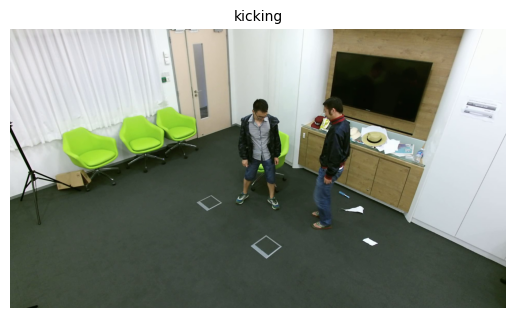

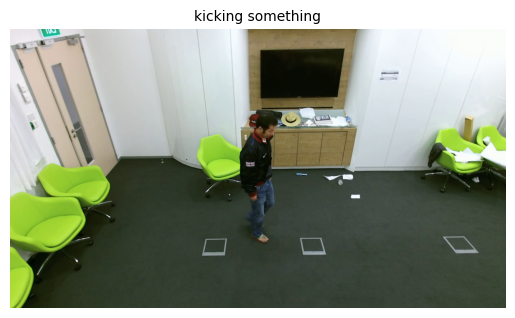

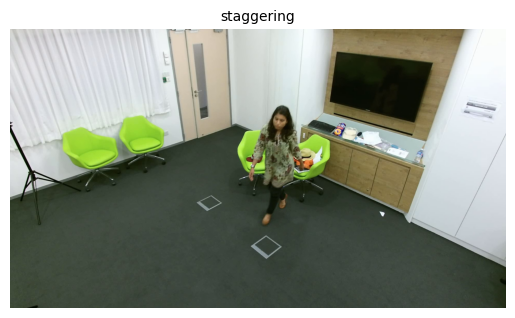

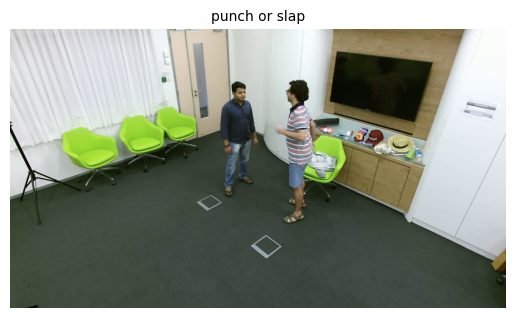

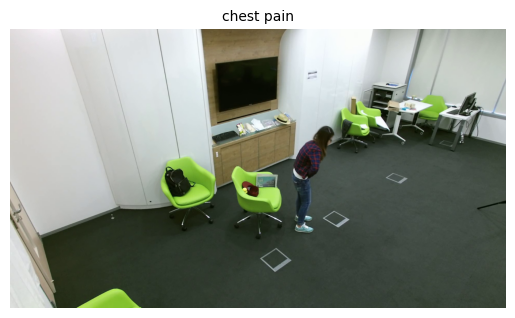

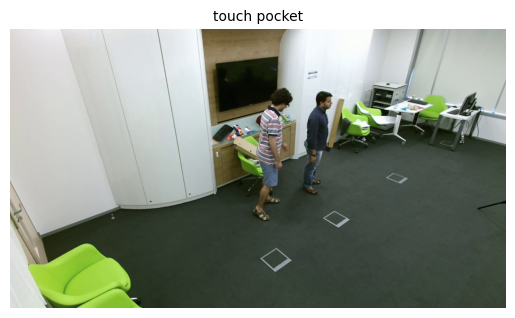

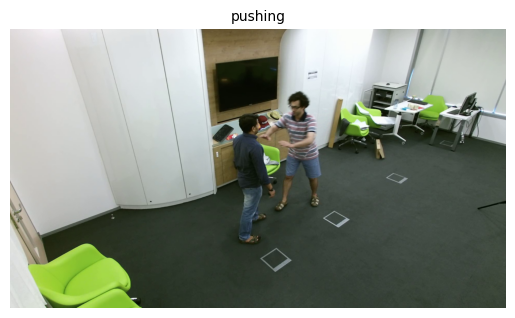

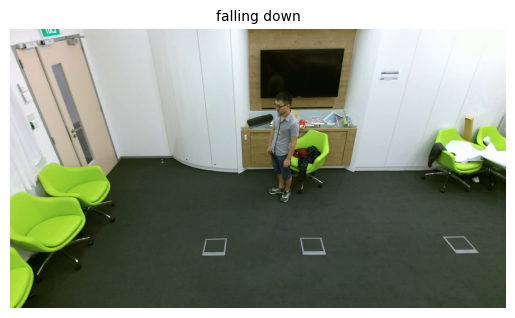

In [7]:
labels_displayed = set()
fig = plt.figure(figsize=(15,15))
for root, dirs, files in os.walk(input_folder):
  # print(root)
  index=0
  for file in files:
      # print( file, root)

      label = os.path.split(os.path.split(root)[0])[1]
      if label in labels_displayed:
        break
      # print(label)
      image_list = os.listdir(os.path.join(root))
      if len(image_list) == 0:
          os.remove(os.path.join(input_folder,label))
      img = random.choice(image_list)
      img = Image.open(os.path.join(root,img))

      fig.add_subplot(10,5,index+1)
      plt.imshow(img)
      plt.title(label, fontsize=10)
      plt.axis("off")
      index = index +1
      labels_displayed.add(label)
  plt.show()
        # break

# Extracting keypoints using YOLOv8

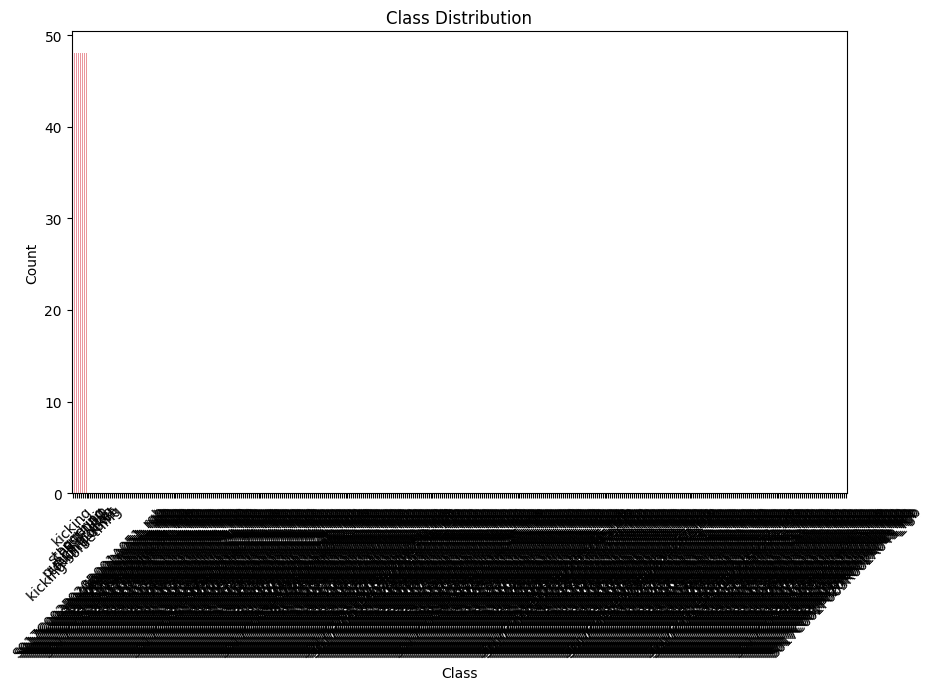

In [8]:
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Function to visualize class distribution
# def visualize_class_distribution(input_folder):
#     class_counts = {}
#     class_names = []
#     for root, dirs, files in os.walk(input_folder):
#         for dir_name in dirs:
#             folder_path = os.path.join(root, dir_name)
#             class_names.append(dir_name)
#             class_counts[dir_name] = len([name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))])

#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=class_names, y=list(class_counts.values()))
#     plt.title('Class Distribution')
#     plt.xlabel('Class')
#     plt.ylabel('Count')
#     plt.xticks(rotation=45)
#     plt.show()

# # Visualize class distribution
# visualize_class_distribution(input_folder)


In [9]:
model_yolo = YOLO("yolov8x-pose-p6.pt")

100%|██████████| 190M/190M [00:00<00:00, 233MB/s]  


In [10]:
data = []
for label in os.listdir(input_folder):
  print(label)
  label_dir = os.path.join(input_folder,label)
  for video in os.listdir(label_dir):
    video_dir = os.path.join(label_dir,video)
    print(video_dir)
    features = []
    for img in os.listdir(video_dir):
        image = os.path.join(video_dir,img)
        # Extracting keypoint with YOLOv8
        results = model_yolo.predict(image, boxes=False, verbose=False)
        for r in results:
            keypoints = r.keypoints.xyn.cpu().numpy()[0]
            keypoints = keypoints.reshape((1, keypoints.shape[0]*keypoints.shape[1]))[0].tolist()
            # features.append(keypoints)
            # keypoints.append(image) #insert image path
            # keypoints.append(label) #insert image label
            features.extend(keypoints)
    features.append(video_dir)
    features.append(label)
    data.append(features)
  # index=0
  # for file in files:
  #     # print( file, root)
  #     label = os.path.split(os.path.split(root)[0])[1]

kicking
/kaggle/working/input_frame/kicking/S017C002P020R001A051_rgb
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use '

In [11]:
# Print the length of the data list and the first few elements
print("Length of data:", len(data))
if len(data) > 0:
    print("First element:", data[0])
else:
    print("Data list is empty.")
print(len(data[0]))


Length of data: 384
First element: [0.6374071836471558, 0.29814955592155457, 0.6399601697921753, 0.28725534677505493, 0.0, 0.0, 0.6541651487350464, 0.2871503531932831, 0.0, 0.0, 0.6567164659500122, 0.35291415452957153, 0.6817201972007751, 0.33955225348472595, 0.6505769491195679, 0.445075124502182, 0.6855571866035461, 0.4140591621398926, 0.6392596364021301, 0.5104215145111084, 0.6806631088256836, 0.47942057251930237, 0.6430110335350037, 0.4960102140903473, 0.6625277400016785, 0.48841121792793274, 0.6012682914733887, 0.5685976147651672, 0.6394121646881104, 0.570302426815033, 0.6162013411521912, 0.6656686067581177, 0.6345762014389038, 0.6640374064445496, 0.5106149315834045, 0.32303744554519653, 0.5146787166595459, 0.311148464679718, 0.5053572654724121, 0.3123216927051544, 0.0, 0.0, 0.49183204770088196, 0.2969476580619812, 0.5260246396064758, 0.3318057060241699, 0.4772093594074249, 0.3347006142139435, 0.5380323529243469, 0.3975059390068054, 0.4685332179069519, 0.4049782454967499, 0.5373789

insert extracted keypoints into dataset. I will remove nose from my features

In [12]:
total_features = len(data[0])
df = pd.DataFrame(
    data=data,
    columns=[f"x{i}" for i in range(total_features)]
    ).rename({
        "x340":"image_path", "x341":"label"
        }, axis=1)

df = df.dropna() #delete undetected pose
df = df.iloc[:, 2:]

print(f"Total features {len(df.columns)-2}")
df.head()

Total features 338


x2        x3        x4        x5        x6        x7        x8  \
0  0.639960  0.287255  0.000000  0.000000  0.654165  0.287150  0.000000   
1  0.682981  0.324046  0.675771  0.319818  0.698957  0.324512  0.000000   
2  0.636680  0.252663  0.627914  0.250899  0.650913  0.254381  0.000000   
3  0.000000  0.000000  0.623963  0.356972  0.000000  0.000000  0.606465   
4  0.549237  0.253957  0.541049  0.258846  0.000000  0.000000  0.528152   

         x9       x10       x11  ...      x332      x333      x334      x335  \
0  0.000000  0.656716  0.352914  ...  0.526731  0.539508  0.477272  0.536640   
1  0.000000  0.708653  0.376652  ...  0.682667  0.577325  0.660448  0.560446   
2  0.000000  0.662631  0.315856  ...  0.638397  0.534817  0.607417  0.518957   
3  0.355522  0.591428  0.400965  ...  0.560002  0.594572  0.581898  0.615000   
4  0.265961  0.560322  0.303938  ...  0.717824  0.571032  0.698157  0.532238   

       x336      x337      x338      x339  \
0  0.528937  0.605749  0.472893  0.589582   
1  0.678467  0.645167  0.656399  0.618601   
2  0.630610  0.601278  0.606562  0.574271   
3  0.544165  0.670836  0.588275  0.705897   
4  0.717890  0.642484  0.696231  0.603731   

                                          image_path    label  
0  /kaggle/working/input_frame/kicking/S017C002P0...  kicking  
1  /kaggle/working/input_frame/kicking/S017C003P0...  kicking  
2  /kaggle/working/input_frame/kicking/S017C003P0...  kicking  
3  /kaggle/working/input_frame/kicking/S017C001P0...  kicking  
4  /kaggle/working/input_frame/kicking/S017C001P0...  kicking  

[5 rows x 340 columns]

In [13]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

classes_dict = {key:le.inverse_transform([key])[0] for key in range(len(df['label'].unique()))}
num_classes = len(classes_dict)

print(f"Total classes: {num_classes} ")
print(classes_dict)

Total classes: 8 
{0: 'chest pain', 1: 'falling down', 2: 'kicking', 3: 'kicking something', 4: 'punch or slap', 5: 'pushing', 6: 'staggering', 7: 'touch pocket'}


# Split and Load Data

In [15]:
# import torch
# from sklearn.model_selection import train_test_split

# # Assuming X and y are your features and labels
# X = df.drop(["label","image_path"], axis=1).values
# y = df['label'].values

# # Convert numerical data to float32
# X = X.astype('float32')

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Convert the NumPy arrays to PyTorch tensors
# X_train_tensor = torch.tensor(X_train)
# X_test_tensor = torch.tensor(X_test)
# y_train_tensor = torch.tensor(y_train)
# y_test_tensor = torch.tensor(y_test)


In [35]:
X = df.drop(["label","image_path"], axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

In [17]:
# import torch
# from torch.utils.data import TensorDataset
# from sklearn.model_selection import train_test_split

# # Assuming X_train, y_train, X_test, and y_test are your train and test data
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.long)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.long)

# # Create TensorDataset objects for train and test data
# train_tensor = TensorDataset(X_train, y_train)
# test_tensor = TensorDataset(X_test, y_test)


In [38]:
train_tensor = TensorDataset(X_train, y_train)
test_tensor = TensorDataset(X_test, y_test)

In [39]:
BATCH_SIZE = 15

train_dataloader = DataLoader(dataset=train_tensor, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_tensor, batch_size=BATCH_SIZE, shuffle=False)

# Training Function

In [40]:
accuracy_score = Accuracy(task="multiclass", num_classes=num_classes).to(device)
f1_score = F1Score(task="multiclass", num_classes=num_classes).to(device)

def train_step(model, dataloader, optimizer, loss_fn):
    model.train()
    train_loss, train_acc, train_f1 = 0, 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        #loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #accuracy
        logits = torch.softmax(y_pred, dim=1)
        class_prediction = torch.argmax(logits, dim=1)
        acc = accuracy_score(class_prediction, y)
        f1 = f1_score(class_prediction, y)
        train_acc += acc.item()
        train_f1 += f1.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    train_f1 /= len(dataloader)

    return train_loss, train_acc, train_f1

def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc, test_f1 = 0, 0, 0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            #loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            #accuracy
            logits = torch.softmax(y_pred, dim=1)
            class_prediction = torch.argmax(logits, dim=1)
            acc = accuracy_score(class_prediction, y)
            f1 = f1_score(class_prediction, y)
            test_acc += acc.item()
            test_f1 += f1.item()

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    test_f1 /= len(dataloader)
    return test_loss, test_acc, test_f1

In [41]:
def train_loop(model, trainloader, testloader, optimizer, loss_fn, epochs, verbose=True):
    history = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "test_loss": [],
        "test_accuracy": [],
        "test_f1": [],
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_f1 = train_step(
            model=model,
            dataloader=trainloader,
            optimizer=optimizer,
            loss_fn=loss_fn
        )

        test_loss, test_acc, test_f1 = test_step(
            model=model,
            dataloader=testloader,
            loss_fn=loss_fn
        )

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_acc)
        history['test_f1'].append(test_f1)

        # Checkpoint
        best = max(history['test_accuracy'])
        best_epoch = history['test_accuracy'].index(best)

        if test_acc < best:
            status = f"Accuracy not improved from epoch {best_epoch}"
        else:
            status = f"Accuracy improved, saving weight....."
            torch.save(model.state_dict(), 'best.pth')

        if verbose:
            print(f"Epoch {epoch}")
            print(f"train loss: {train_loss} | test loss: {test_loss}")
            print(f"train accuracy: {train_acc} | test accuracy: {test_acc}")
            print(f"train f1: {train_f1} | test f1: {test_f1}")
            print(status)
            print("-------------------------------------------------")

    print(f"Best accuracy on epoch: {best_epoch}, accuracy: {best}")
    return history, best_epoch

In [42]:
def plot_result(train, test, ax, title, best_epoch):
    ax.plot(train, label='train')
    ax.plot(test, label='test')
    ax.axvline(x=best_epoch, color='blue', linestyle='--')
    ax.set_title(title)
    ax.legend()

# Make the model

In [43]:
class PedestrianSafetyClassifier(nn.Module):
  def __init__(self, num_classes, input_length):
    super().__init__()
    self.layer1 = nn.Linear(in_features=input_length, out_features=676)
    self.activation = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.layer2 = nn.Linear(in_features=676, out_features=676)
    self.outlayer = nn.Linear(in_features=676, out_features=num_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.layer2(x)
    x = self.activation(x)
    x = self.outlayer(x)
    return x

input_length = X.shape[1]
model = PedestrianSafetyClassifier(num_classes=num_classes, input_length=input_length).to(device)
summary(model, input_size=(X.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 384, 676]         229,164
              ReLU-2             [-1, 384, 676]               0
           Dropout-3             [-1, 384, 676]               0
            Linear-4             [-1, 384, 676]         457,652
              ReLU-5             [-1, 384, 676]               0
            Linear-6               [-1, 384, 8]           5,416
Total params: 692,232
Trainable params: 692,232
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.50
Forward/backward pass size (MB): 9.93
Params size (MB): 2.64
Estimated Total Size (MB): 13.06
----------------------------------------------------------------


# Tune the Hyperparameter

In [46]:
optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())
loss_fn = nn.CrossEntropyLoss()

# Training Loop

In [47]:
epochs = 3000

result, best = train_loop(
      model=model,
      trainloader=train_dataloader,
      testloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=epochs,
      verbose=True
      )

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 0
train loss: 2.1192884180280895 | test loss: 2.1366150081157684
train accuracy: 0.09686610061261389 | test accuracy: 0.10303030628710985
train f1: 0.09686610061261389 | test f1: 0.10303030628710985
Accuracy improved, saving weight.....
-------------------------------------------------
Epoch 1
train loss: 2.082544830110338 | test loss: 2.090650737285614
train accuracy: 0.1535612584816085 | test accuracy: 0.14469697698950768
train f1: 0.1535612584816085 | test f1: 0.14469697698950768
Accuracy improved, saving weight.....
-------------------------------------------------
Epoch 2
train loss: 2.067321300506592 | test loss: 2.0870653986930847
train accuracy: 0.16296296856469578 | test accuracy: 0.1310606123879552
train f1: 0.16296296856469578 | test f1: 0.1310606123879552
Accuracy not improved from epoch 1
-------------------------------------------------
Epoch 3
train loss: 2.058616194460127 | test loss: 2.1240959465503693
train accuracy: 0.1566951639122433 | test accuracy: 0.1060606

# Evaluation

In [48]:
def model_eval(model, dataloader):
    y_preds = []
    y_true = []
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_logit = model(X)
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            y_preds.append(y_pred)
            y_true.append(y)

    y_pred = torch.cat(y_preds).cpu().numpy()
    y_test = torch.cat(y_true).cpu().numpy()

    report = classification_report(y_pred, y_test)
    cm = confusion_matrix(y_pred, y_test)

    return report, cm

In [49]:
model_pose = PedestrianSafetyClassifier(num_classes=num_classes, input_length=input_length).to(device)
model_pose.load_state_dict(torch.load(f="best.pth"))

<All keys matched successfully>

              precision    recall  f1-score   support

           0       0.36      0.38      0.37        13
           1       0.40      0.57      0.47        14
           2       0.40      0.33      0.36        12
           3       0.17      0.15      0.16        20
           4       0.08      0.12      0.10         8
           5       0.58      0.37      0.45        19
           6       0.38      0.28      0.32        18
           7       0.24      0.33      0.28        12

    accuracy                           0.32       116
   macro avg       0.33      0.32      0.31       116
weighted avg       0.34      0.32      0.32       116



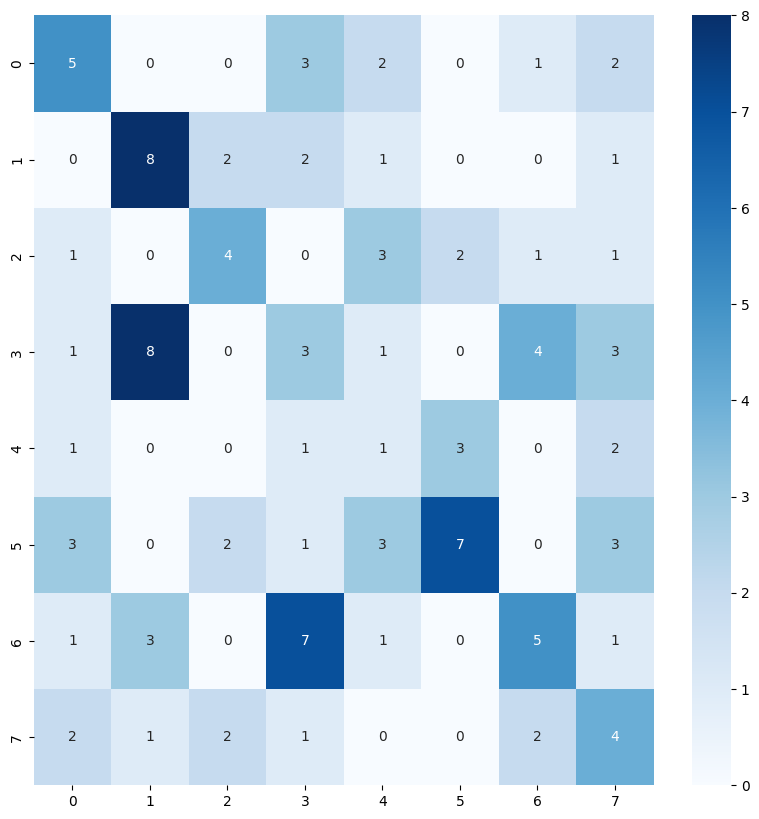

In [50]:
cls_report, cls_cm = model_eval(model, test_dataloader)

print(cls_report)

plt.figure(figsize=(10,10))
sns.heatmap(cls_cm, annot=True, fmt='g', cmap='Blues')
plt.show()

# Make Prediction

In [51]:
model_pose = PedestrianSafetyClassifier(num_classes=num_classes, input_length=input_length).to(device)
model_pose.load_state_dict(torch.load(f="best.pth"))
im_array = []

def make_prediction(video_dir, true_label):
    features = []
    for img in os.listdir(video_dir):
        image = os.path.join(video_dir,img)
        # Extracting keypoint with YOLOv8
        results = model_yolo.predict(image, boxes=False, verbose=False)
        for r in results:
            im_array = r.plot(boxes=False)
            keypoints = r.keypoints.xyn.cpu().numpy()[0]
            keypoints = keypoints.reshape((1, keypoints.shape[0]*keypoints.shape[1]))[0].tolist()
            # features.append(keypoints)
            # keypoints.append(image) #insert image path
            # keypoints.append(label) #insert image label
            features.extend(keypoints)
    # features.append(video_dir)
    # features.append(label)
    # data.append(features)
    print(features)
    #Prediction
    model_pose.cpu()
    model_pose.eval()
    with torch.inference_mode():
        logit = model_pose(torch.tensor(features[2:]))
        pred = torch.softmax(logit, dim=0).argmax(dim=0).item()
        prediction = classes_dict[pred]

    # if prediciton is correct, title color will be green.
    if prediction == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.imshow(im_array[..., ::-1])
    plt.title(f"prediction:{prediction}\ntrue label:{true_label}", color=color)
    plt.show()



In [52]:
# Create a directory if it is not there, so we can save files and results in it
from pathlib import Path
source_folder = '/kaggle/input/external-source/external_source'
Path('/kaggle/working/external_input').mkdir(parents=True, exist_ok=True)
input_folder = '/kaggle/working/external_input'
extract_frames(source_folder, input_folder)

Creating.../kaggle/working/external_input/kicking something/Copy of S017C003P020R002A024_rgb/19.png
Creating.../kaggle/working/external_input/kicking something/Copy of S017C003P020R002A024_rgb/20.png
Creating.../kaggle/working/external_input/kicking something/Copy of S017C003P020R002A024_rgb/21.png
Creating.../kaggle/working/external_input/kicking something/Copy of S017C003P020R002A024_rgb/22.png
Creating.../kaggle/working/external_input/kicking something/Copy of S017C003P020R002A024_rgb/23.png
Creating.../kaggle/working/external_input/kicking something/Copy of S017C003P020R002A024_rgb/24.png
Creating.../kaggle/working/external_input/kicking something/Copy of S017C003P020R002A024_rgb/25.png
Creating.../kaggle/working/external_input/kicking something/Copy of S017C003P020R002A024_rgb/26.png
Creating.../kaggle/working/external_input/kicking something/Copy of S017C003P020R002A024_rgb/27.png
Creating.../kaggle/working/external_input/kicking something/Copy of S017C003P020R002A024_rgb/28.png


In [ ]:
# Path to the folder containing the videos
#source_folder = '/kaggle/input/external-source'

# Define the output folder where processed videos will be saved
#input_folder = '/kaggle/working/external_input'

#extract_frames(source_folder, input_folder)

WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be rem

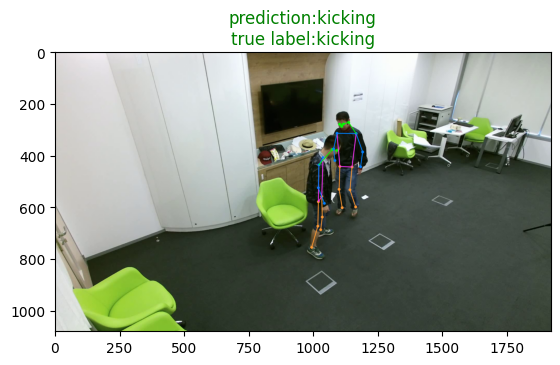

WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be rem

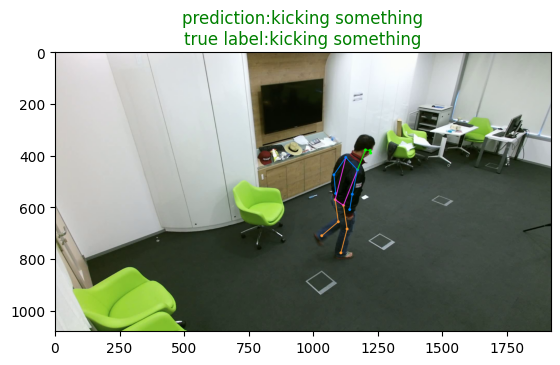

WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be rem

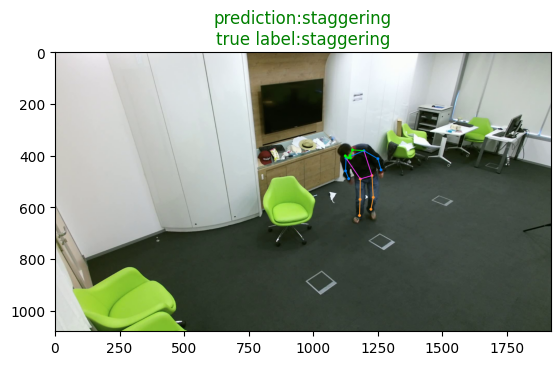

WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be rem

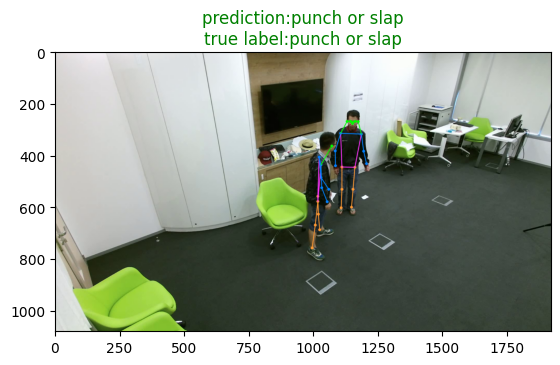

WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be rem

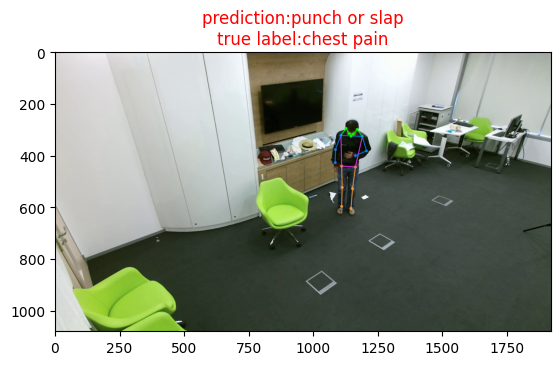

WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be rem

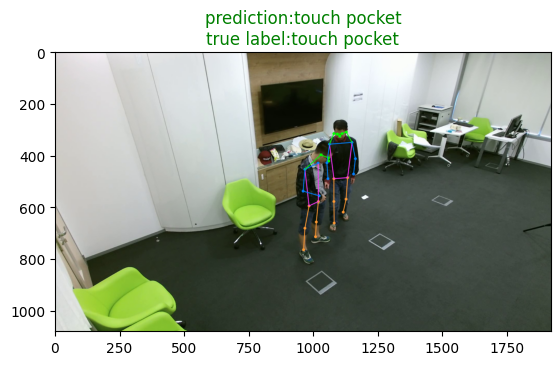

WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be rem

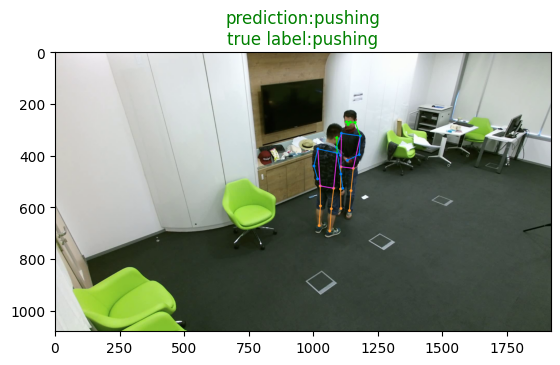

WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_boxes' instead.
WARNING ⚠️ 'boxes' is deprecated and will be rem

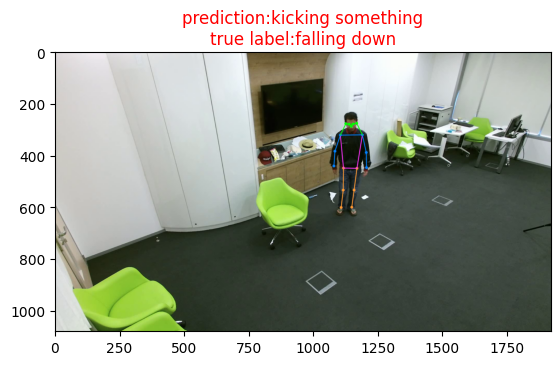

In [53]:
for label in os.listdir(input_folder):
    # if label == 'Poses.json':
    #     continue

    true_label = label

    # image_list = os.listdir(os.path.join(image_folder,label))
    # if len(image_list) == 0:
    #     continue

    # img = random.choice(image_list)
    # img = os.path.join(image_folder,label,img)
    for video in os.listdir(os.path.join(input_folder,label)):
      # print(video, label)
      video_dir = os.path.join(input_folder,label,video)
      # print(video_dir)
      make_prediction(video_dir, true_label)